# SVD-based (image) compression

As an exercise in applying the SVD, this notebook asks you to apply it to the literal problem of compression, in this case for images.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from PIL import Image

def im2gnp(image):
    """Converts a PIL image into an image stored as a 2-D Numpy array in grayscale."""
    return np.array(image.convert ('L'))

def gnp2im(image_np):
    """Converts an image stored as a 2-D grayscale Numpy array into a PIL image."""
    return Image.fromarray(image_np.astype(np.uint8), mode='L')

def imshow_gray(im, ax=None):
    if ax is None:
        f = plt.figure()
        ax = plt.axes()
    ax.imshow(im,
              interpolation='nearest',
              cmap=plt.get_cmap('gray'))

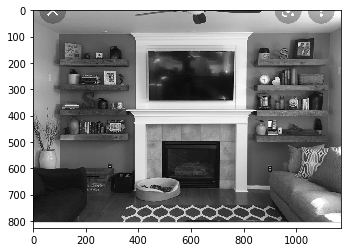

In [4]:
pic_raw = Image.open('image_from_internet.jpeg')
pic = im2gnp(pic_raw)
imshow_gray(pic)

In [5]:
pic.shape

(827, 1170)

**Exercise 0** (1 point). Write a function that, given a Numpy array-representation of a (grayscale) image, returns its size in pixels.

In [6]:
def sizeof_image(I):
    assert type(I) is np.ndarray
    assert len(I.shape) == 2
    return I.shape[0] * I.shape[1]

sizeof_image (pic)


967590

## Compression via the truncated SVD

Recall that the $k$-truncated SVD gives the best rank-$k$ approximation to a matrix $A$. That is, if the SVD of $A$ is $A = U \Sigma V^T$, then we can approximate $A$ by

$$
  A \approx U_k \Sigma_k V_k^T,
$$

where $(U_k, \Sigma_k, V_k^T)$ is the $k$-truncated SVD, taken by retaining the $k$ largest singular values (entries of diagonal matrix $\Sigma$), as well as the first $k$ columns of the left and right singular vectors ($U$ and $V$).

**Key idea.** For the rest of this notebook, if you understand the following idea, then the rest should make sense.

Suppose we represent the image as a matrix, $A$. Then we can also approximate $A$ with its $k$-truncated SVD, $(U_k, \Sigma_k, V_k^T)$. **If you can choose $k$ so that the size of the representation, $(U_k, \Sigma_k, V_k^T)$, is less than the size of original image, then we have compressed it.**

**Exercise 1** (2 point). Write a function, `compress_image(I, k)`, that compresses an input image `I` by interpreting `I` as a matrix, computing the `k`-truncated SVD, and returning a compressed representation.

For this function, we want you to return a tuple, `(S, Uk, VkT)`, where `S` is an array of _all_ the singular values (not just the top $k$) and `Uk` and `VkT` are the $k$-_truncated_ singular vectors.

In [7]:
def compress_image(I, k):
    Uk, Sigma, VkT = np.linalg.svd(I)
    return Sigma, Uk[:, :k],  VkT[:k, :]
    


# Runs your function:
k = 10
Sigma, Uk, VkT = compress_image(pic, k)

print(Sigma.shape)
print(Uk.shape)
print(VkT.shape)


(827,)
(827, 10)
(10, 1170)


**Exercise 2** (2 points). Write a function, `sizeof_compressed_image()`, that returns the number of "equivalent pixels" used by the compressed (truncated SVD) representation.

What are "equivalent pixels?" Recall these facts:

- In the original grayscale image, only 1 byte is needed to store each pixel.
- In the (truncated) SVD representation, each matrix entry is a double-precision value, which requires 8 bytes.

In your implementation of this function, you may count just the $k$ largest singular values even though we asked that your `compress_image()` function return _all_ of the singular values.

In [8]:
def sizeof_compressed_image(Sigma, Uk, VkT):
    print(len(Uk))
    print(len(VkT.T))
    return ((k*len(Uk)) + k + (k*len(VkT.T)))*8


**Exercise 3** (2 points). Recall that the error of the compressed representation, as measured in the squared Frobenius norm, is given by the sum of the trailing singular values,

$$
  \|A - U_k \Sigma_k V_k^T\|_F^2 = \sigma_{k}^2 + \sigma_{k+1}^2 + \cdots + \sigma_{s-1}^2,
$$

where $s = \min(m, n)$ if $A$ is $m \times n$ and we assume that the singular values are sorted from largest ($\sigma_0$) to smallest ($\sigma_{s-1}$).

Write a function that returns the _relative_ error, measured using the Frobenius norm, i.e.,

$$
  \dfrac{\|A - U_k \Sigma_k V_k^T\|_F}
        {\|A\|_F}
        .
$$

In [9]:
def compression_error (Sigma, k):
    """
    Given the singular values of a matrix, return the
    relative reconstruction error.
    """

    return np.sqrt(sum(Sigma[k:]**2)) / np.sqrt(sum(Sigma**2))

compression_error(Sigma, k)


0.15415726305716418

**Exercise 4** (2 points). Write a function that, given the compressed representation of an image, reconstructs it approximately.

In [10]:
def uncompress_image(Sigma, Uk, VkT):
    assert Uk.shape[1] == VkT.shape[0]
    return np.dot(Uk[:, :k], np.dot(np.diag(Sigma[:k]), VkT[:k, :]))    
    

**Exercise 5** (3 points). Write a function that, given the singular values of an image, determines the truncation point, $k$, that would reduce the relative error below a desired threshold.

> _Hint:_ You may find Numpy's [cumulative sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) handy.

In [11]:
def find_rank(rel_err_target, Sigma):
    
    c = []
    
    for i in range(100):
        c.append(compression_error(Sigma, i))
        
    target = []
        
    for index, error in enumerate(c):
        if error < rel_err_target:
            target.append(index)
            
    return min(target)
    
    
rel_err_target = 0.10
k_target = find_rank(rel_err_target, Sigma)

print("Relative error target:", rel_err_target)
print("Suggested value of k:", k_target)

Relative error target: 0.1
Suggested value of k: 25


In [12]:
k=25

Compressing...
827
1170
Estimated compression ratio: 2.4x


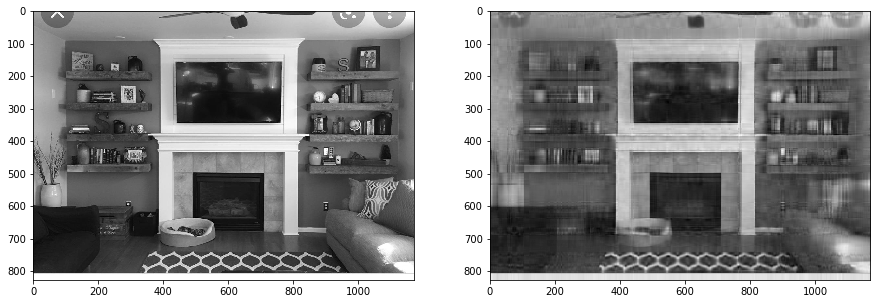

In [14]:
pic_pixels = sizeof_image (pic)
print("Compressing...")
Sigma_target, Uk_target, VkT_target = compress_image(pic, k_target)
target_pixels = sizeof_compressed_image(Sigma_target,
                                        Uk_target,
                                        VkT_target)
target_ratio = pic_pixels / target_pixels
print("Estimated compression ratio: {:.1f}x".format(target_ratio))

pic_target = uncompress_image(Sigma_target, Uk_target, VkT_target)
f, ax = plt.subplots(1, 2, figsize=(15, 30))
imshow_gray(pic, ax[0])
imshow_gray(pic_target, ax[1])



In [15]:
rel_err_target = 0.05
k_target = find_rank(rel_err_target, Sigma)

print("Relative error target:", rel_err_target)
print("Suggested value of k:", k_target)

Relative error target: 0.05
Suggested value of k: 83


In [16]:
k=83

Compressing...
827
1170
Estimated compression ratio: 0.7x


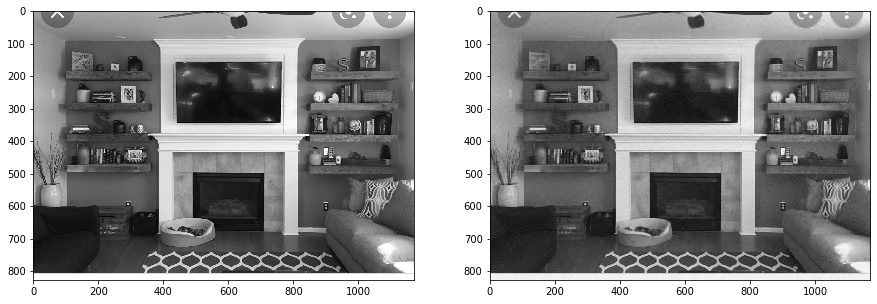

In [17]:
print("Compressing...")
Sigma_target, Uk_target, VkT_target = compress_image(pic, k_target)
target_pixels = sizeof_compressed_image(Sigma_target,
                                        Uk_target,
                                        VkT_target)
target_ratio = pic_pixels / target_pixels
print("Estimated compression ratio: {:.1f}x".format(target_ratio))

pic_target = uncompress_image(Sigma_target, Uk_target, VkT_target)
f, ax = plt.subplots(1, 2, figsize=(15, 30))
imshow_gray(pic, ax[0])
imshow_gray(pic_target, ax[1])